# Network Analysis

In this notebook we are conducting exploratory analysis on the graphs created from the data in `data/games/network_raw` and `data/games/network`. We are also using the metadata available in `data/games/metadata/all_games.csv`. List of questions that we aim to answer:

 * What kind of games do people play?
 * Do communities form around a series of games or a single game in a series?
 * Are there 'cliques' in speedrunning or are users more homogeneous?
 * What are the most popular games?
 * Do popular games have common properties?
 * Who makes the games that are the most 'speedrunnable'?
 * What differences are there between the most popular and least popular games?
 * How many games are there on speedrun.com?
 * How many games are *played* on speedrun.com?
 * Are there any issues with the data?
 * How should we deal with the issues in the data?
 * What are the statistics behind the different games on speedrun.com?
 

In [1]:
import csv
import collections

import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from datetime import datetime
from operator import itemgetter
from functools import reduce


In [2]:
FINAL_DATE = datetime(2023, 1, 1)

# Helper Functions

In [3]:
def generate_network_filter(filename: str, disallowed_games=None, allowed_games=None):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        filter_map = defaultdict(bool)
        for row in csv_reader:
            # Check if the created/release date is after 2023, if it is then we can ignore it in the network.
            release_date = datetime.strptime(row[3], "%Y-%m-%d")
            if row[4] == "None":
                row[4] = "2017-10-22T05:21:29Z" # This is a completely random date before the final date.
            created_date = datetime.strptime(row[4], "%Y-%m-%dT%H:%M:%SZ")

            if disallowed_games == None:
                disallowed_games = ["y65797de"]

            if allowed_games == None:
                if created_date < FINAL_DATE and release_date < FINAL_DATE and row[0] not in disallowed_games:
                    filter_map[row[0]] = True
            else:
                if created_date < FINAL_DATE and release_date < FINAL_DATE and row[0] not in disallowed_games and row[0] in allowed_games:
                    filter_map[row[0]] = True

    return filter_map

def get_weighted_edges_from_csv(filename, filter=None):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)

        edges = list()
        for row in csv_reader:
            if filter is None:
                edges.append(tuple([row[0], row[1], int(row[2])]))
                continue
            
            if not filter.get(row[0]) or not filter.get(row[1]):
                continue

            edges.append(tuple([row[0], row[1], int(row[2])]))

    return edges

def generate_graph_from_edges(edges_list):
    directed_graph = nx.DiGraph()
    directed_graph.add_weighted_edges_from(edges_list)
    return directed_graph

def save_weighted_graph(g: nx.DiGraph, filename: str):
    with open(filename, 'w', encoding='utf-8') as openfile:
        openfile.write("Source,Target,Weight\n")
        for source,target,data in g.edges(data=True):
            weight = int(data['weight'])
            output_string = ','.join(map(str, [source, target, weight]))
            openfile.write(f"{output_string}\n")

In [4]:
def format_games_metadata_dataframe(df: pd.DataFrame):
    # Remove row if game do not have a created date.
    df.drop(df[df['created_date'] == 'None'].index, inplace=True)
    
    # Remove rows with N/As in them.
    df = df.dropna()
    
    # Format the release_date and created_date to be an actual date type.
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['created_date'] = pd.to_datetime(df['created_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['release_date'] = pd.to_datetime(df['release_date'].dt.strftime('%Y-%m-%d'))
    df['created_date'] = pd.to_datetime(df['created_date'].dt.strftime('%Y-%m-%d'))
    
    # Remove rows with a created date or release date before cutoff.
    df = df[(df['created_date'] < '2023-01-01') & (df['release_date'] < '2023-01-01')] 
    
    # Format numeric data into a numeric data type.
    df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
    
    # Rename the game_id column to just id.
    df.rename(columns = {'game_id' : 'id'}, inplace=True)

    return df

In [5]:
def get_graph_order_size(g: nx.Graph):
    return g.order(), g.size()

# Exploratory Analysis

We are generating a network using the entire related games network that has been filtered using the previously mentioned function. This gives us a directed graph with **30,433 nodes**, and **14,739,311 edges**. Without filtering, we get a network that has **30,970 nodes** and **14,857,762 edges**. The filtering removes **537 nodes** and **118,451 edges**. The degree analysis of our network reveals a few insights. **The most popular node with respect to degree centrality is `k6q4rqzd` or Seterra**. We have also created a loglog plot of degree count. **What does this mean?**

Looking at the degrees with weights, the numbers are a little suspicious on some of the games. We can see that `Nerf Test Range` has the second highest in degree with weights value, despite having only 4844 runs. We can explain this with the following: A user that has played many games, but one game *far more* than the others, will show up many times in the edges going from all the games they have played. For example, if I play 4 games and in game 2 I have 1000 runs, then the edges of the network will be the following:

```
(1, 2) = 1000
(1, 3) = 2
(1, 4) = 4
(2, 1) = 1
(2, 3) = 1
(2, 4) = 1
(3, 1) = 1
(3, 2) = 1000
(3, 4) = 14
(4, 1) = 4
(4, 2) = 1000
(4, 3) = 2

in_degree_with_weight(2) = 3000
in_degree(2) = 3
out_degree_with_weight(2) = 1
out_degree(2) = 1
```

We can see that even though only one player has played game 2 it is by far the most popular looking at in degree with weights. This mean that we probably can't use this metric to define anything useful.

In [6]:
games_metadata_filename = "../data/games/metadata/all_games.csv"
games_metadata_df = pd.read_csv(games_metadata_filename)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [7]:
games_metadata_df.describe()

,num_categories,num_levels,num_runs,num_users,num_guests
count,32994.000000,32994.000000,32994.000000,32994.000000,32994.000000
mean,3.966115,7.046736,97.471934,20.651331,1.898891
std,4.397084,31.464601,686.818141,130.675756,89.318618
min,0.000000,0.000000,-999.000000,-999.000000,-999.000000
25%,2.000000,0.000000,3.000000,2.000000,0.000000
50%,3.000000,0.000000,10.000000,4.000000,0.000000
75%,5.000000,5.000000,39.000000,10.000000,0.000000
max,183.000000,2042.000000,61962.000000,7168.000000,15646.000000


In [8]:
games_metadata_df.sort_values(by='num_runs').tail().iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
5162,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36
16315,y65797de,Subway Surfers,None,2012-05-24,2017-06-25T17:41:20Z,13,0,39623,-999,-999
4924,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452
23519,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14
20434,w6jrzxdj,Speed Builders,None,2016-01-29,2017-03-03T03:33:28Z,1,2042,25083,261,9


In [9]:
games_metadata_df.sort_values(by='num_users').tail().iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
5162,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36
15794,j1npme6p,Minecraft: Java Edition,k62d97ex,2011-11-18,2015-01-29T23:41:21Z,15,0,18329,6268,491
4924,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452
16941,pd0py36e,ROBLOX: Speed Run 4,yzol0kzq,2013-01-01,2015-10-14T00:39:39Z,9,33,11303,5636,20
23519,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14


In [10]:
games_metadata_df.sort_values(by='num_guests').tail().iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
16295,yd478gde,Minecraft: Legacy Console Edition,"yzom2keq,yge00xep",2012-05-09,2015-01-29T23:42:25Z,11,12,19379,155,15646
22528,m1z9l2d0,Hypixel BedWars,w63x8j6x,2017-06-21,2017-08-26T17:36:09Z,12,0,6597,4402,2349
26761,j1llrpz1,ROBLOX: Piggy,w63pvpzx,2020-01-23,2020-03-23T07:00:00Z,14,0,7382,2320,1321
17478,ldep0513,Final Fantasy XIV: Endwalker,qvegwk60,2013-08-24,2016-09-25T19:14:00Z,13,318,5290,926,1319
25719,yd4oq3k1,ROBLOX: Tower Defense Simulator,4zw7526k,2019-06-05,2020-03-25T15:16:10Z,13,49,6231,2825,1033


In [7]:
filter_filename = "../data/games/metadata/all_games.csv"
graph_filename = "../data/too_big/all_games_filtered.csv"
filter_map = generate_network_filter(filter_filename)
edges = get_weighted_edges_from_csv(graph_filename, filter=filter_map)
filtered_graph = generate_graph_from_edges(edges)
print(f"FILTERED: {get_graph_order_size(filtered_graph)}")

FILTERED: (30433, 14739311)


In [12]:
graph_filename = "../data/too_big/all_games.csv"
edges = get_weighted_edges_from_csv(graph_filename, filter=None)
unfiltered_graph = generate_graph_from_edges(edges)
print(f"UNFILTERED: {get_graph_order_size(unfiltered_graph)}")

UNFILTERED: (30970, 14857762)


In [13]:
# Cleanup
del filter_filename, graph_filename, filter_map, edges, unfiltered_graph, games_metadata_filename

We should now look at a degree analysis of the network.

In [14]:
out_degrees = pd.DataFrame(filtered_graph.out_degree()).rename(columns = {0: 'id', 1: 'out_degree'})
out_degrees_with_weight = pd.DataFrame(filtered_graph.out_degree(weight='weight')).rename(columns = {0: 'id', 1: 'out_degree_with_weight'})
in_degrees = pd.DataFrame(filtered_graph.in_degree()).rename(columns = {0: 'id', 1: 'in_degree'})
in_degrees_with_weight = pd.DataFrame(filtered_graph.in_degree(weight='weight')).rename(columns = {0: 'id', 1: 'in_degree_with_weight'})

In [15]:
games_metadata_filename = "../data/games/metadata/all_games.csv"
games_metadata_df = pd.read_csv(games_metadata_filename)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [16]:
all_dataframes = [games_metadata_df, out_degrees, out_degrees_with_weight, in_degrees, in_degrees_with_weight]
degree_df = reduce(lambda left,right: pd.merge(left,right,on='id', how='inner'), all_dataframes)
degree_df.describe()

,num_categories,num_levels,num_runs,num_users,num_guests,out_degree,out_degree_with_weight,in_degree,in_degree_with_weight
count,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,3.044000e+04
mean,4.055125,7.372208,103.919284,22.278581,2.077135,484.306078,2121.236958,484.306537,2.120896e+03
std,4.461197,32.478199,677.609514,135.789522,92.810672,869.869936,5361.872510,869.825237,2.138506e+04
min,1.000000,0.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.000000,0.000000,4.000000,2.000000,0.000000,26.000000,72.000000,26.000000,3.900000e+01
50%,3.000000,0.000000,12.000000,4.000000,0.000000,97.000000,310.500000,97.000000,1.840000e+02
75%,5.000000,5.000000,44.000000,11.000000,0.000000,416.000000,1530.000000,417.000000,1.040000e+03
max,183.000000,2042.000000,61962.000000,7168.000000,15646.000000,9206.000000,151023.000000,9211.000000,2.005087e+06


In [18]:
degree_df.sort_values(by='in_degree_with_weight', ascending=True).tail(3).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,out_degree,out_degree_with_weight,in_degree,in_degree_with_weight
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,9206,151023,9211,2005087
18148,j1ne0vl1,Nerf Test Range,None,2015-01-01,2021-03-13T23:11:48Z,13,30,4844,43,0,4482,60028,4484,1643535
25802,nd285r3d,Catapult Quest,None,2020-06-18,2022-02-12T11:53:22Z,10,550,3478,24,1,4081,55002,4088,1093294


In [19]:
degree_df.sort_values(by='in_degree', ascending=True).tail(10).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,out_degree,out_degree_with_weight,in_degree,in_degree_with_weight
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,9206,151023,9211,2005087
22112,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14,7491,65403,7488,67573
4671,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452,7294,101462,7302,64853
12755,k6q474zd,Minecraft (Classic),None,2009-05-17,2020-09-15T18:21:08Z,11,0,4563,2599,14,6850,89935,6855,45083
463,om1m3625,Super Mario Bros.,xv6dvx62,1985-09-13,None,5,0,8018,1737,31,6794,56136,6795,36025
21027,46w0n91r,Mario Kart 8 Deluxe,xv6dvx62,2017-04-28,2017-04-30T00:26:59Z,10,0,15196,3046,20,6683,60844,6696,75854
11462,9d3rv59d,Bee Movie Game (DS),81e7o2z7,2007-10-30,2019-08-01T15:40:10Z,2,0,236,221,3,6648,61961,6656,12970
10396,3dxz7p1y,New Super Mario Bros.,None,2006-05-15,2015-02-04T09:13:58Z,8,80,3787,708,20,6294,53153,6299,67495
1765,pd0wq31e,Super Mario World,xv6dvx62,1990-11-21,None,13,0,9820,1830,38,6288,46669,6293,38886
35,76rmo418,Pac-Man,None,1980-05-22,2016-09-27T00:08:16Z,4,0,331,143,4,6001,28759,6004,14677


In [20]:
in_degrees_with_weight = [d for n, d in filtered_graph.in_degree(weight='weight')]
in_degrees = [d for n, d in filtered_graph.in_degree()]
out_degrees_with_weight = [d for n, d in filtered_graph.out_degree(weight='weight')]
out_degrees = [d for n, d in filtered_graph.out_degree()]

In [21]:
in_degree_with_weights_counts = sorted(collections.Counter(in_degrees_with_weight).items(), key=itemgetter(1), reverse=True)
in_degree_counts = sorted(collections.Counter(in_degrees).items(), key=itemgetter(1), reverse=True)
out_degree_with_weights_counts = sorted(collections.Counter(out_degrees_with_weight).items(), key=itemgetter(1), reverse=True)
out_degree_counts = sorted(collections.Counter(out_degrees).items(), key=itemgetter(1), reverse=True)

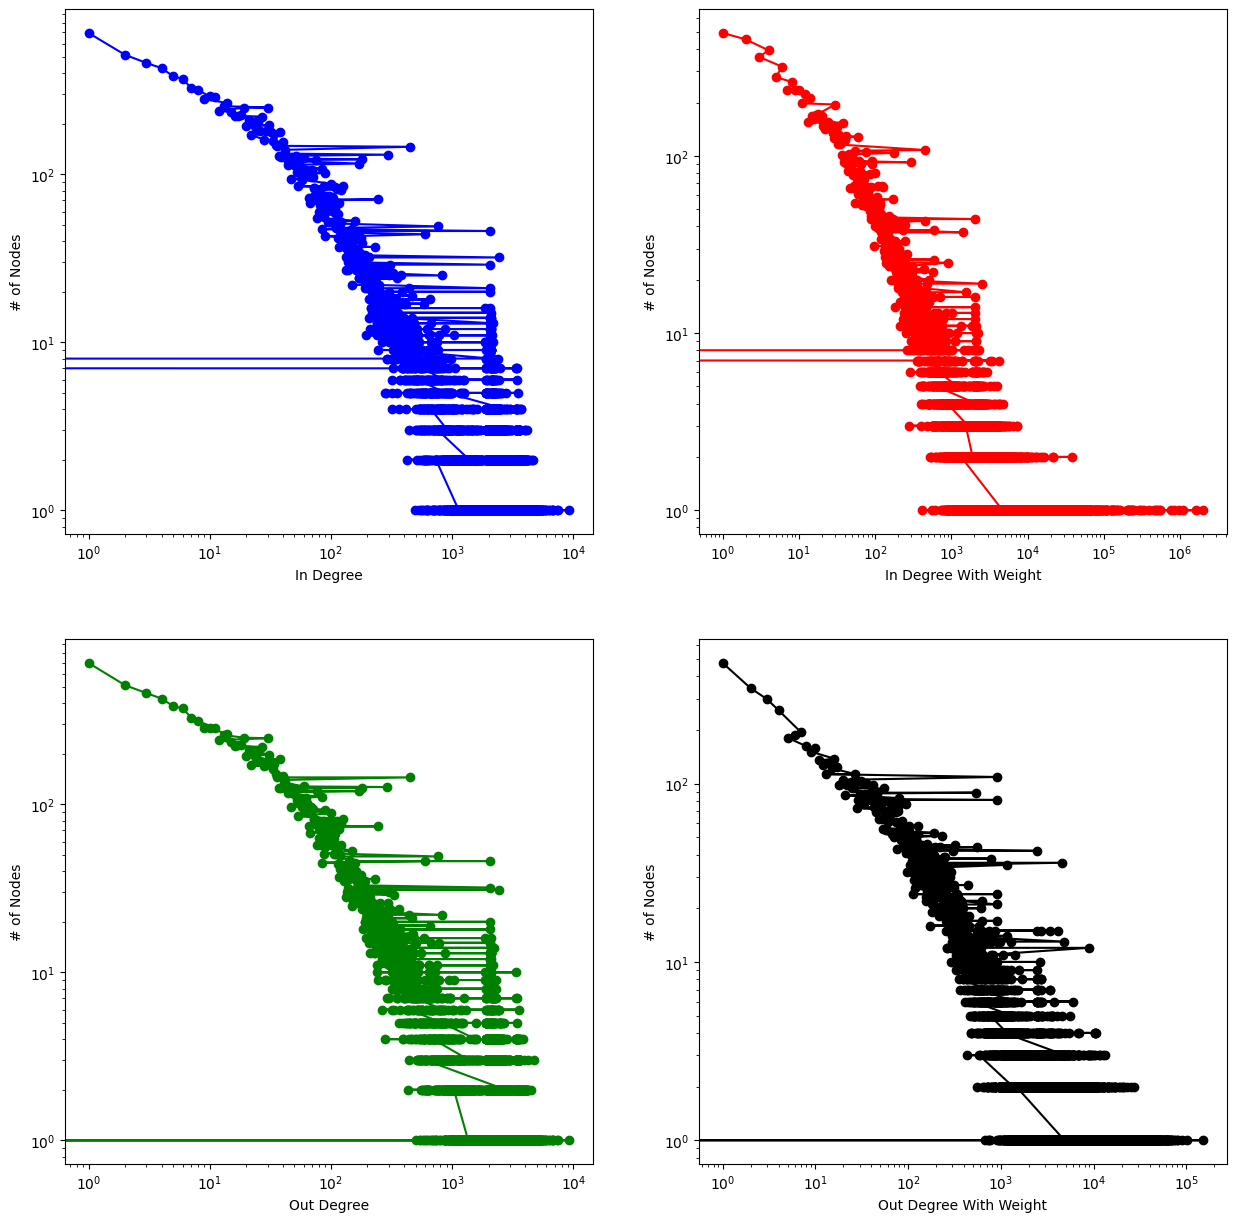

In [22]:
fig, ax = plt.subplots(2, 2)

x, y = list(zip(*in_degree_counts))
ax[0, 0].loglog(x, y,'bo-')
ax[0, 0].set_ylabel("# of Nodes")
ax[0, 0].set_xlabel("In Degree")

x, y = list(zip(*in_degree_with_weights_counts))
ax[0, 1].loglog(x, y, 'ro-')
ax[0, 1].set_ylabel("# of Nodes")
ax[0, 1].set_xlabel("In Degree With Weight")

x, y = list(zip(*out_degree_counts))
ax[1, 0].loglog(x, y,'go-')
ax[1, 0].set_ylabel("# of Nodes")
ax[1, 0].set_xlabel("Out Degree")

x, y = list(zip(*out_degree_with_weights_counts))
ax[1, 1].loglog(x, y, 'ko-')
ax[1, 1].set_ylabel("# of Nodes")
ax[1, 1].set_xlabel("Out Degree With Weight")

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()


In [23]:
# Cleanup
del games_metadata_df, degree_df, all_dataframes, games_metadata_filename
del in_degrees_with_weight, in_degrees, out_degrees, out_degrees_with_weight
del in_degree_with_weights_counts, in_degree_counts, out_degree_counts, out_degree_with_weights_counts
del fig, ax, x, y

## Connected Components of the Games Network

The graph is composed of **38 weakly connect components** and **47 strongly connected components**. This means that instead of one large graph creating our network, we have several components that create the overall graph. Inspecting these components, we find one massive component and multiple incredibly small components. This means that **we have a main graph that is extremely well connected**, and **several disconnected sub-graphs**. This means that **the average player plays popular games that many other players have played**. We can inspect these small components and find that they are rare cycles where there are only a few players of a game, and those players have *only* played those games.  

In [24]:
print(f"IS WEAKLY CONNECTED: {nx.is_weakly_connected(filtered_graph)}")
print(f"IS STRONGLY CONNECTED: {nx.is_strongly_connected(filtered_graph)}")

IS WEAKLY CONNECTED: False
IS STRONGLY CONNECTED: False


In [25]:
print(f"NO. OF WEAKLY CONNECTED COMPONENTS: {nx.number_weakly_connected_components(filtered_graph)}")
print(f"NO. OF STRONGLY CONNECTED COMPONENTS: {nx.number_strongly_connected_components(filtered_graph)}")

NO. OF WEAKLY CONNECTED COMPONENTS: 38
NO. OF STRONGLY CONNECTED COMPONENTS: 47


In [26]:
weak_components = sorted([component for component in nx.weakly_connected_components(filtered_graph)], key=len, reverse=True)
strong_components = sorted([component for component in nx.strongly_connected_components(filtered_graph)], key=len, reverse=True)

largest_weak_component = len(max(weak_components, key=len))
largest_strong_component = len(max(strong_components, key=len))

print(f"Largest weak component: {largest_weak_component}\nLargest strong component: {largest_strong_component}")

Largest weak component: 30344
Largest strong component: 30335


In [27]:
games_metadata_filename = "../data/games/metadata/all_games.csv"
games_metadata_df = pd.read_csv(games_metadata_filename)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[[
    'num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns={'game_id': 'id'}, inplace=True)

In [28]:
games_list = weak_components[1]
games_metadata_df[(games_metadata_df['id'].isin(games_list))]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
25061,m1zknp31,Sapporo Station 1980,None,2018-12-31,2021-10-15T01:03:23Z,4,0,1,1,0
26671,3698gv0d,Sapporo Station 2012,None,2019-12-31,2021-11-03T20:39:20Z,4,0,1,1,0
27231,pd0q7lv1,Sapporo Station 2020,None,2020-05-05,2021-11-03T20:38:11Z,4,0,1,1,0
29153,k6qw47x6,New Hokkaido 4000km,None,2021-03-22,2021-05-20T19:21:51Z,6,0,14,3,0
30998,ldej0wl1,Hokkaido 4500km,None,2021-12-31,2022-01-13T21:09:30Z,4,0,8,2,0


In [31]:
# Cleanup
del weak_components, strong_components, largest_weak_component, largest_strong_component, games_metadata_df, games_list, games_metadata_df

## Centrality Analysis

In this section we look at the various types of centrality: Closeness, Hyperlink-Induced Topic Search (Hits), Pagerank, and Betweenness. Centrality metrics recognise nodes that are important or central among the whole list of other nodes in a graph.

 * Degree Centrality: The higher the degree of the node, the more crucial it is to the graph. It is used to find popular nodes, most connected nodes, or nodes that hold the most information.
 * Closeness Centrality: A node's importance is based on how 'close' it is to all the other nodes in the graph. We define closeness as the number of edges between two nodes.
 * Hits Centrality: A good hub node represents a node that pointed to many other nodes, while a good authority node represents a node that is linked by many different hub nodes.
 * Pagerank Centrality: A node's importance is based on the direction of the edges connecting to/from a node.
 * Betweenness Centrality: A node's importance is based on the number of times it appears in the shortest paths between other nodes. It is essentially a percetage of nodes in the network that have that node in their shortest paths.

In [33]:
closeness_centrality_filename = "../data/games/network/centrality/closeness_centrality.csv"
hits_centrality_filename = "../data/games/network/centrality/hits_centrality.csv"
pagerank_filename = "../data/games/network/centrality/pagerank.csv"
betweenness_centrality_filename = "../data/games/network/centrality/betweenness_centrality.csv"

closeness_centrality_df = pd.read_csv(closeness_centrality_filename).rename(columns = {'value': 'closeness_value'})
hits_centrality_df = pd.read_csv(hits_centrality_filename)
pagerank_df = pd.read_csv(pagerank_filename).rename(columns = {'value': 'pagerank_value'})
betweenness_centrality_df = pd.read_csv(betweenness_centrality_filename).rename(columns = {'value': 'betweenness_value'})

games_metadata_filename = "../data/games/metadata/all_games.csv"
games_metadata_df = pd.read_csv(games_metadata_filename)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns={'game_id': 'id'}, inplace=True)

In [34]:
all_dataframes = [games_metadata_df, closeness_centrality_df, hits_centrality_df, pagerank_df, betweenness_centrality_df]
merged_df = reduce(lambda left,right: pd.merge(left,right,on='id'), all_dataframes)
merged_df.describe(include='all')

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
count,30440,30440,30440,30440,30440,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,30439.000000,3.044000e+04,3.044000e+04,30440.000000,3.044000e+04
unique,30433,30414,7886,8317,29654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,v1pxwk86,Dreams,None,2015-01-01,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,3,17222,357,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,4.055125,7.372208,103.919284,22.278581,2.077135,0.319274,3.461664e-04,1.363310e-03,0.000033,5.611297e-05
std,NaN,NaN,NaN,NaN,NaN,4.461197,32.478199,677.609514,135.789522,92.810672,0.049550,5.721256e-03,5.567596e-03,0.000205,2.735144e-04
min,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,-999.000000,0.000000,0.000000,0.006737,0.000000e+00,0.000000e+00,0.000005,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,4.000000,2.000000,0.000000,0.295556,5.467181e-07,1.721085e-07,0.000007,5.762778e-08
50%,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,12.000000,4.000000,0.000000,0.317954,4.130517e-06,1.949215e-06,0.000011,3.268143e-06
75%,NaN,NaN,NaN,NaN,NaN,5.000000,5.000000,44.000000,11.000000,0.000000,0.344057,3.769929e-05,9.420492e-05,0.000025,3.254986e-05


<Axes: >

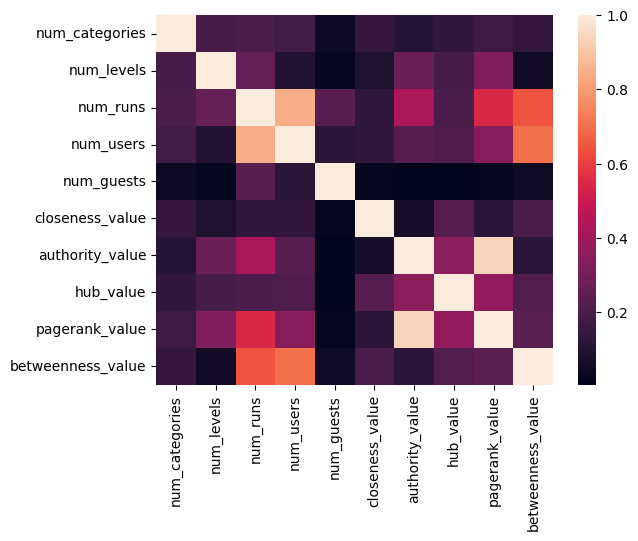

In [35]:
sns.heatmap(merged_df.corr())

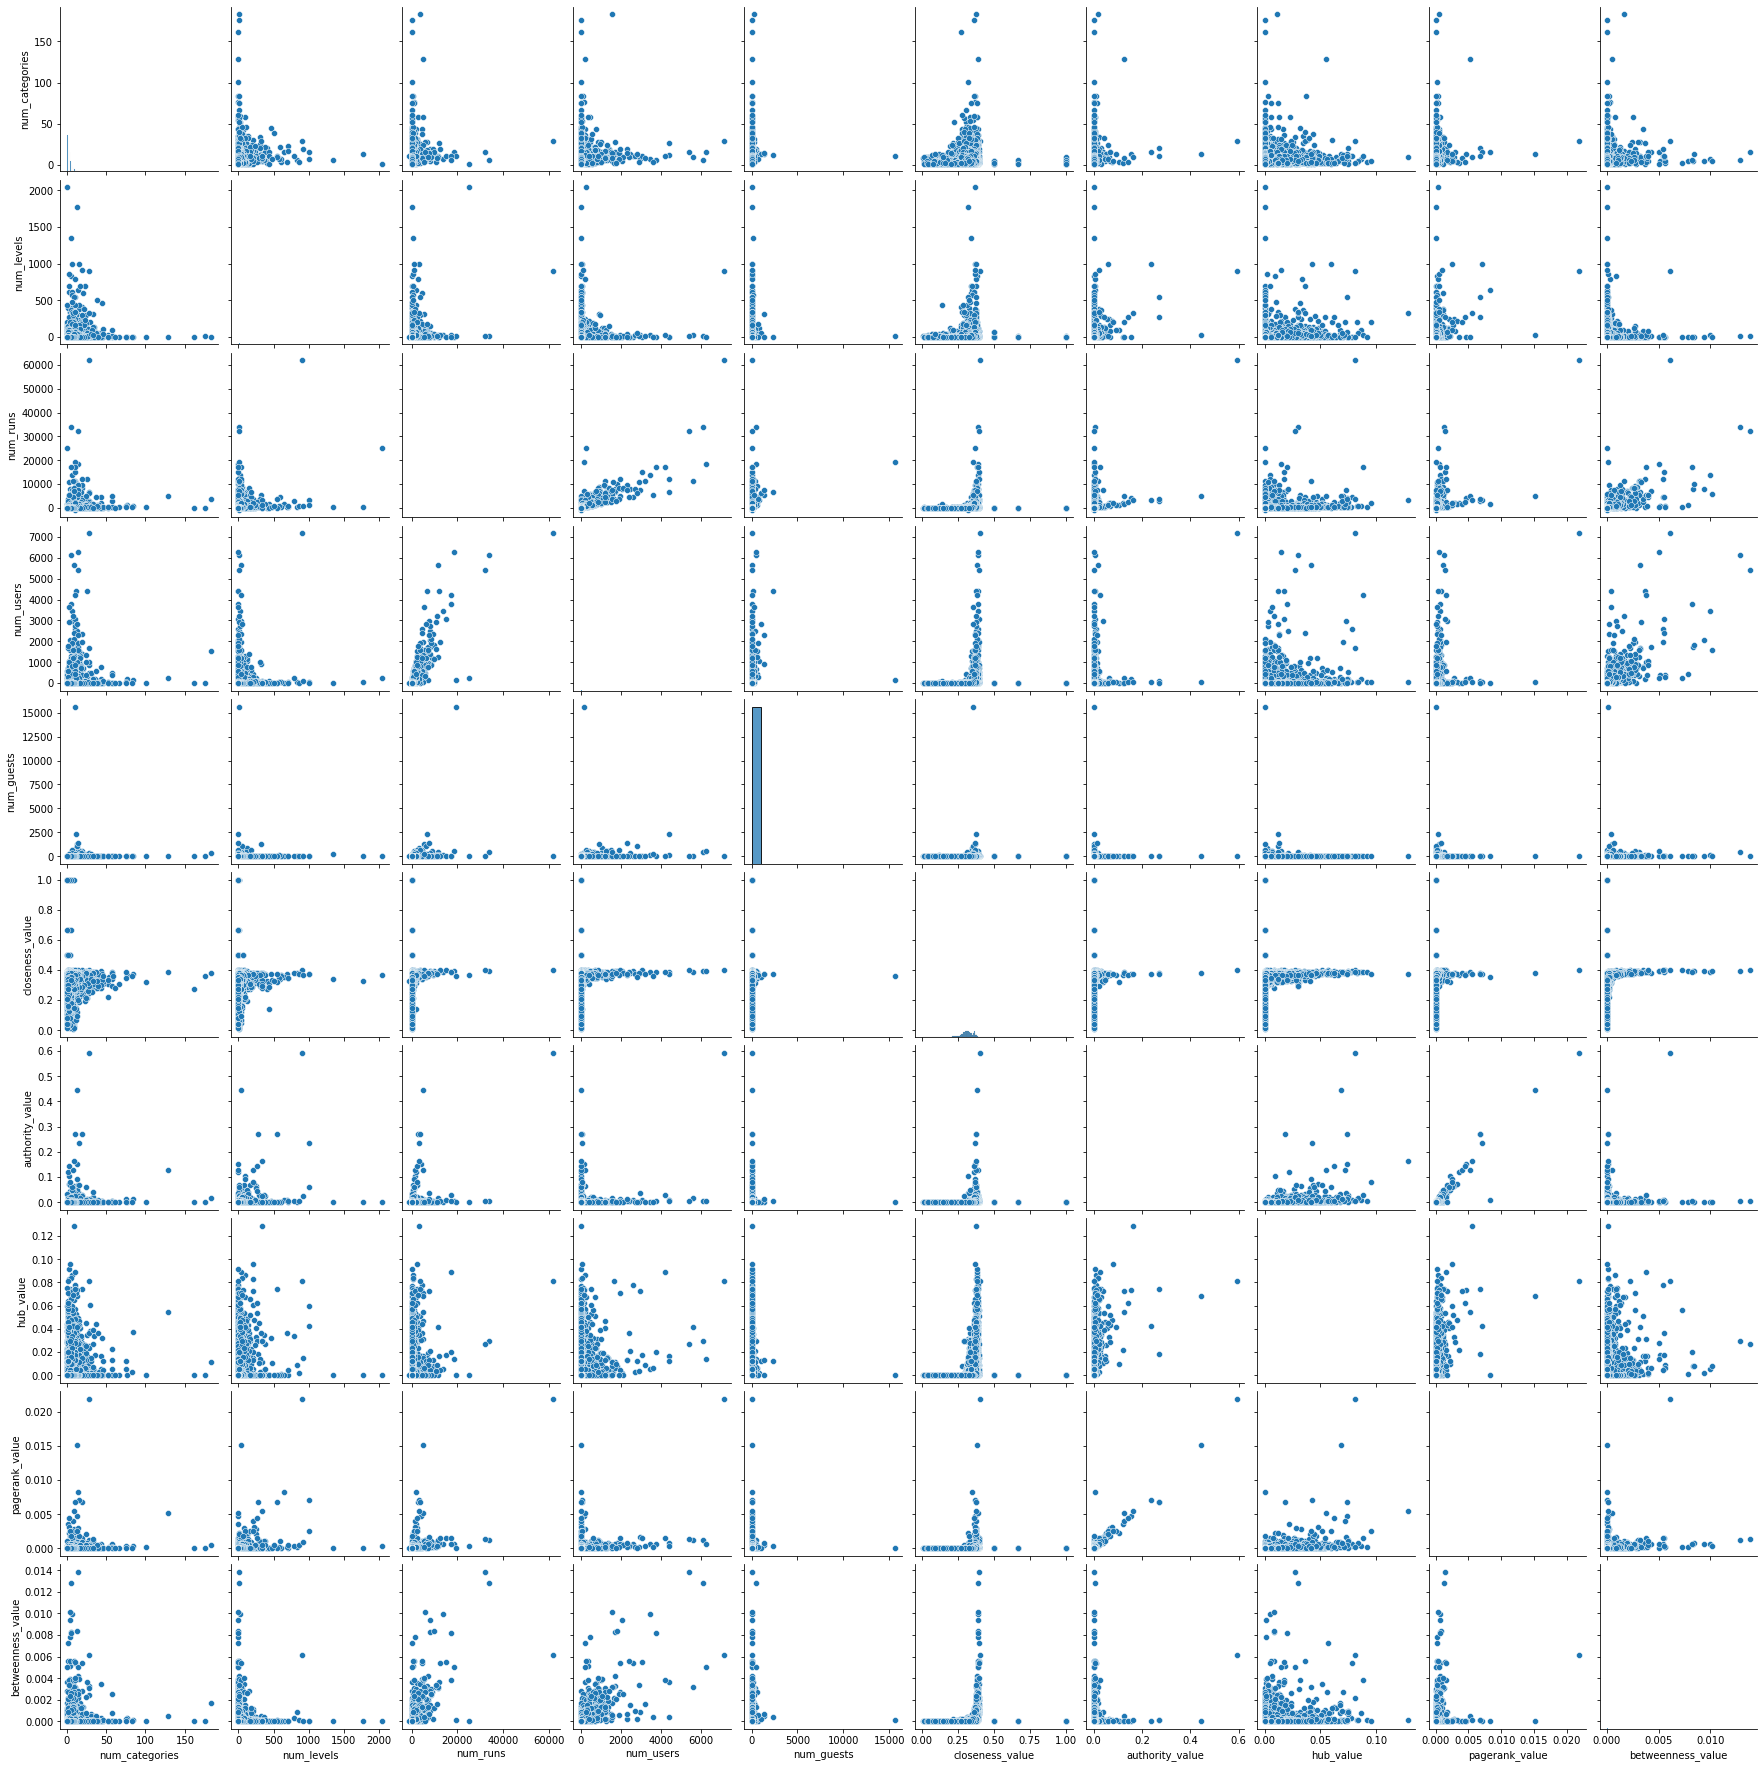

In [91]:
sns.pairplot(merged_df)

In [56]:
tmp_df = merged_df.groupby(['developers'])
grouped_merged_df = tmp_df.sum(numeric_only=True)
grouped_merged_df['num_games_per_developer'] = tmp_df.count().iloc[:, 0]
del tmp_df

### Closeness Centrality

In [57]:
top_n_values = 5
merged_df.sort_values(by="closeness_value", ascending=True).head(top_n_values).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
26492,9d38wje1,Tiny Toy Tanks,None,2020-10-25,2021-07-25T15:46:00Z,2,0,2,2,0,0.019180,1.074341e-08,3.622988e-08,0.000005,0.0
28064,yd4k0kk6,Dark Roll: Free Kick Challenge,None,2021-08-05,2021-09-16T18:07:52Z,1,0,8,3,0,0.016969,6.777964e-10,1.293167e-08,0.000005,0.0
24301,nd28wxed,Sky: Children of the Light Category Extensions,4nel1l62,2019-07-18,2021-08-28T16:03:20Z,9,0,3,5,0,0.016428,6.602013e-07,6.508087e-07,0.000005,0.0
23787,pdv2q8v6,KDA Fan Game,rzj1rpzl,2019-02-26,2022-11-09T16:29:58Z,4,4,61,5,0,0.014984,3.933716e-09,6.207582e-08,0.000006,0.0
9047,3dxkz2y1,Homecoming: City of Heroes Incarnate Trials,"pe11o3eo,1zkw02zj",2004-04-28,2021-08-09T17:57:45Z,8,8,8,1,0,0.006737,1.487012e-13,5.502745e-12,0.000010,0.0


In [69]:
closeness_df = grouped_merged_df.copy()
closeness_df['average_closeness_value'] = closeness_df['hub_value'] / closeness_df['num_games_per_developer']
closeness_df[['average_closeness_value', 'closeness_value', 'num_games_per_developer']].sort_values(by="average_closeness_value", ascending=True).tail(top_n_values).iloc[::-1]

,average_closeness_value,closeness_value,num_games_per_developer
developers,,,
pe1wp36o,0.088676,0.384508,1
pe13wyzo,0.086131,0.385652,1
"4eppvoer,ne410dem",0.081210,0.401198,1
"yz8jyq6w,ge0x5pep,p6xr8261",0.074356,0.387514,1
4epx73zr,0.072942,0.381256,1


### Hubs and Authorities Centrality

In [70]:
merged_df.sort_values(by="hub_value", ascending=True).tail(top_n_values).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
26245,o1yj5n21,Perfect Golf - Satisfying Game,None,2020-09-08,2021-12-13T18:15:51Z,9,333,3103,31,0,0.375387,0.164470,0.128835,0.005509,0.000090
28973,9do8lpk1,Maze (Coolmath Games),None,2022-01-01,2022-07-19T14:20:27Z,4,200,2133,55,0,0.371184,0.078550,0.095686,0.002526,0.000022
23451,m1mnnojd,Factris,None,2018-12-09,2021-06-04T20:06:14Z,3,0,145,46,1,0.383090,0.005934,0.091759,0.000248,0.000153
21613,o1y9pyk6,Google Snake,pe1wp36o,2017-09-27,2020-01-19T12:16:58Z,11,32,17105,4236,8,0.384508,0.027298,0.088676,0.001578,0.003797
19294,4d790zr1,Tomb of the Mask,pe13wyzo,2016-02-19,2018-05-27T19:18:48Z,7,100,703,206,0,0.385652,0.008909,0.086131,0.000412,0.000772


In [71]:
merged_df.sort_values(by="authority_value", ascending=True).tail(top_n_values).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,0.401198,0.593570,0.081210,0.021878,0.006154
18148,j1ne0vl1,Nerf Test Range,None,2015-01-01,2021-03-13T23:11:48Z,13,30,4844,43,0,0.382091,0.445458,0.068188,0.015118,0.000067
13192,3dx2j9y1,Angry Birds,None,2009-12-01,2017-11-13T02:19:32Z,20,274,2897,95,2,0.377780,0.271052,0.018274,0.006820,0.000159
25802,nd285r3d,Catapult Quest,None,2020-06-18,2022-02-12T11:53:22Z,10,550,3478,24,1,0.375735,0.270346,0.074065,0.006812,0.000090
13887,j1ll47v1,ROBLOX: Longest Obby in Roblox | 1000+ Obstacl...,None,2010-10-13,2017-10-03T02:35:53Z,16,999,3354,71,1,0.372519,0.236636,0.042675,0.007070,0.000070


In [72]:
hub_df = grouped_merged_df.copy()
hub_df['average_hub_value'] = hub_df['hub_value'] / hub_df['num_games_per_developer']
hub_df[['average_hub_value', 'hub_value', 'num_games_per_developer']].sort_values(by="average_hub_value", ascending=True).tail(top_n_values).iloc[::-1]

,average_hub_value,hub_value,num_games_per_developer
developers,,,
pe1wp36o,0.088676,0.088676,1
pe13wyzo,0.086131,0.086131,1
"4eppvoer,ne410dem",0.081210,0.081210,1
"yz8jyq6w,ge0x5pep,p6xr8261",0.074356,0.074356,1
4epx73zr,0.072942,0.072942,1


In [73]:
authority_hub = grouped_merged_df.copy()
authority_hub['average_authority_value'] = authority_hub['authority_value'] / authority_hub['num_games_per_developer']
authority_hub[['average_authority_value', 'authority_value', 'num_games_per_developer']].sort_values(by="average_authority_value", ascending=True).tail(top_n_values).iloc[::-1]

,average_authority_value,authority_value,num_games_per_developer
developers,,,
"4eppvoer,ne410dem",0.593570,0.593570,1
3zym21z4,0.127075,0.127075,1
v6dynp62,0.109588,0.219176,2
nelk8vz2,0.067991,0.067991,1
ne4vq1em,0.063301,0.063301,1


### Pagerank

In [74]:
merged_df.sort_values(by="pagerank_value", ascending=True).tail(top_n_values).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,0.401198,0.593570,0.081210,0.021878,0.006154
18148,j1ne0vl1,Nerf Test Range,None,2015-01-01,2021-03-13T23:11:48Z,13,30,4844,43,0,0.382091,0.445458,0.068188,0.015118,0.000067
17543,w6jl9o5d,Final Fantasy Record Keeper,leqowy6w,2014-09-24,2018-04-02T05:08:04Z,15,645,1733,10,0,0.350139,0.007365,0.000073,0.008205,0.000003
13887,j1ll47v1,ROBLOX: Longest Obby in Roblox | 1000+ Obstacl...,None,2010-10-13,2017-10-03T02:35:53Z,16,999,3354,71,1,0.372519,0.236636,0.042675,0.007070,0.000070
13192,3dx2j9y1,Angry Birds,None,2009-12-01,2017-11-13T02:19:32Z,20,274,2897,95,2,0.377780,0.271052,0.018274,0.006820,0.000159


In [75]:
pagerank_df = grouped_merged_df.copy()
pagerank_df['average_pagerank_value'] = pagerank_df['pagerank_value'] / pagerank_df['num_games_per_developer']
pagerank_df[['average_pagerank_value', 'pagerank_value', 'num_games_per_developer']].sort_values(by="average_pagerank_value", ascending=True).tail(top_n_values).iloc[::-1]

,average_pagerank_value,pagerank_value,num_games_per_developer
developers,,,
"4eppvoer,ne410dem",0.021878,0.021878,1
3zym21z4,0.005240,0.005240,1
v6dynp62,0.003640,0.007279,2
nelk8vz2,0.002938,0.002938,1
ne4vq1em,0.002830,0.002830,1


### Betweenness Centrality

In [76]:
merged_df.sort_values(by="betweenness_value", ascending=True).tail(top_n_values).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
22112,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14,0.397440,0.003446,0.026889,0.001419,0.013859
4671,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452,0.392295,0.004056,0.029948,0.001261,0.012831
18834,nd22xvd0,Refunct,ge0ry3ep,2015-10-16,2015-10-20T00:23:48Z,4,0,5669,1568,6,0.390633,0.001111,0.008059,0.000353,0.010138
11395,4pd0n31e,Portal,leqm52zw,2007-10-09,None,7,24,13867,3448,65,0.388646,0.001327,0.005154,0.000617,0.009962
2252,9d3rr0dl,The Legend of Zelda: A Link to the Past,xv6dvx62,1991-11-21,None,4,0,7949,2063,46,0.391460,0.000937,0.001594,0.000624,0.009366


We can do the same, but grouped by the developer -- this gives us the developers with the games that have the highest betweenness centrality. **The higher the sum of the value, the more common it is for games by this developer to be an entry game into speedrunning.**

In [77]:
bc_df = grouped_merged_df.copy()
bc_df['average_betweenness'] = bc_df['betweenness_value'] / bc_df['num_games_per_developer']
bc_df[['average_betweenness', 'betweenness_value', 'num_games_per_developer']].sort_values(by="average_betweenness", ascending=True).tail(top_n_values).iloc[::-1]

,average_betweenness,betweenness_value,num_games_per_developer
developers,,,
1zk4q26j,0.007265,0.014529,2
"4eppvoer,ne410dem",0.006154,0.006154,1
1e7do1e7,0.004234,0.004234,1
"xv6dvx62,p6xlqm61,5yz8gx6w,4rzj1zlk",0.004013,0.004013,1
4ep7k3er,0.003844,0.003844,1


In [78]:
bc_df[['average_betweenness', 'betweenness_value', 'num_games_per_developer']].sort_values(by="betweenness_value", ascending=True).tail(top_n_values).iloc[::-1]

,average_betweenness,betweenness_value,num_games_per_developer
developers,,,
None,0.000042,0.726940,17222
xv6dvx62,0.000851,0.091023,107
myzo3pzq,0.000208,0.036892,177
1zk4q26j,0.007265,0.014529,2
2jevn26k,0.000080,0.012255,154


In [79]:
import requests
developer = "leqm52zw"
response = requests.get(f"https://speedrun.com/api/v1/developers/{developer}")
print(response.json().get("data"))

{'id': 'leqm52zw', 'name': 'Valve', 'links': [{'rel': 'self', 'uri': 'https://www.speedrun.com/api/v1/developers/leqm52zw'}, {'rel': 'games', 'uri': 'https://www.speedrun.com/api/v1/games?developer=leqm52zw'}]}


By grouping our dataframe by developer and summing the value column, we get the developers that have the highest betweenness centrality of their games. We find that the top developer is `None`. This means that no developer was listed in the speedrun.com API. The next valid value is `xv6dvx62`, which is Nintendo. Therefore, **Nintendo creates games that are most likely to get people into speedrunning**. In order, the next developers are Capcom, Matt Makes Games Inc., Seterra, Marianne Wartoft, Konami, Vicarious Visions, Dominique Grieshofer, SEGA, StudioMDHR Entertainment Inc., Mojang, Toby Fox, Namco, A crossover between Nintendo, Bandai Namco, Sora Ltd., then CLTincknell, Activision, snk, Mateusz Skutnik, KaMiZoTo, and Treyarch.

* [Nintendo](https://nintendo.fandom.com/wiki/List_of_Nintendo_games). Everyone knows Nintendo as it has literally *raised* most adults.
* [Capcom](https://en.wikipedia.org/wiki/List_of_Capcom_games) is previously a titan of arcade games, and owner of franchises such as Street Fighter, Marvel vs. Capcom, Mega Man, Resident Evil, Devil May Cry, Dead Rising, Monster Hunter, Sengoku Basara, Onimusha and Ace Attorney. 
* [Matt Makes Games Inc.](https://www.mattmakesgames.com/) creates games such as Earthblade, Celeste, Towerfall.
* [Marianne Wartoft](https://wartoft.se/) is the creator of Seterra, and created the studio Seterra to continue the development of that website.
* [Konami](https://en.wikipedia.org/wiki/List_of_Konami_games#:~:text=PlayStation%20handhelds%20%20%20%20Title%20%20,July%2018%2C%202019%20%2025%20more%20rows%20) is similar to Capcom. Konami's video game franchises include Metal Gear, Silent Hill, Castlevania, Contra, Frogger, Tokimeki Memorial, Parodius, Gradius, Yu-Gi-Oh!, Suikoden, and eFootball.
* [Vicarious Visions](https://en.wikipedia.org/wiki/Vicarious_Visions) is a game studio that has created a lot of movie tie-in games.
* [Dominique Grieshofer](https://store.steampowered.com/dev/DomGries) has created games such as Refunct and Swarmlake.
* [StudioMDHR Entertainment Inc.](http://studiomdhr.com/about-us/) created Cuphead and the sequel Cuphead: The Delicious Last Course.
* [Mojang](https://www.minecraft.net/en-us/article/meet-mojang-studios) created Minecraft and it's derivatives.
* [Toby Fox](https://en.wikipedia.org/wiki/Toby_Fox) developed Undertale and Deltarune. 
* [Namco](https://en.wikipedia.org/wiki/List_of_Namco_games) is a published credited with creating Pac-Man, and later merged with Bandai.
* [Bandi Namco](https://en.wikipedia.org/wiki/List_of_Bandai_Namco_video_games) is the successor of Namco. They have TONNES of games.
* etc...

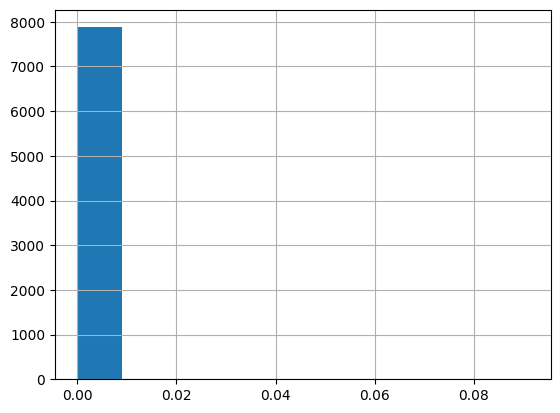

In [80]:
bc_df_without_none = bc_df[(bc_df.index != "None")].sort_values(by="betweenness_value").iloc[::-1]
bc_df_without_none['betweenness_value'].hist()
plt.show()

/var/folders/fp/pwtrzcy130zdfcx62mp9_kmc0000gn/T/ipykernel_7306/4176545528.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_date'] = pd.to_datetime(df['release_date'])
/var/folders/fp/pwtrzcy130zdfcx62mp9_kmc0000gn/T/ipykernel_7306/4176545528.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_date'] = pd.to_datetime(df['created_date'], format='%Y-%m-%dT%H:%M:%SZ')
/var/folders/fp/pwtrzcy130zdfcx62mp9_kmc0000gn/T/ipykernel_7306/4176545528.py:11: SettingWithCopyWarning: 
A value i

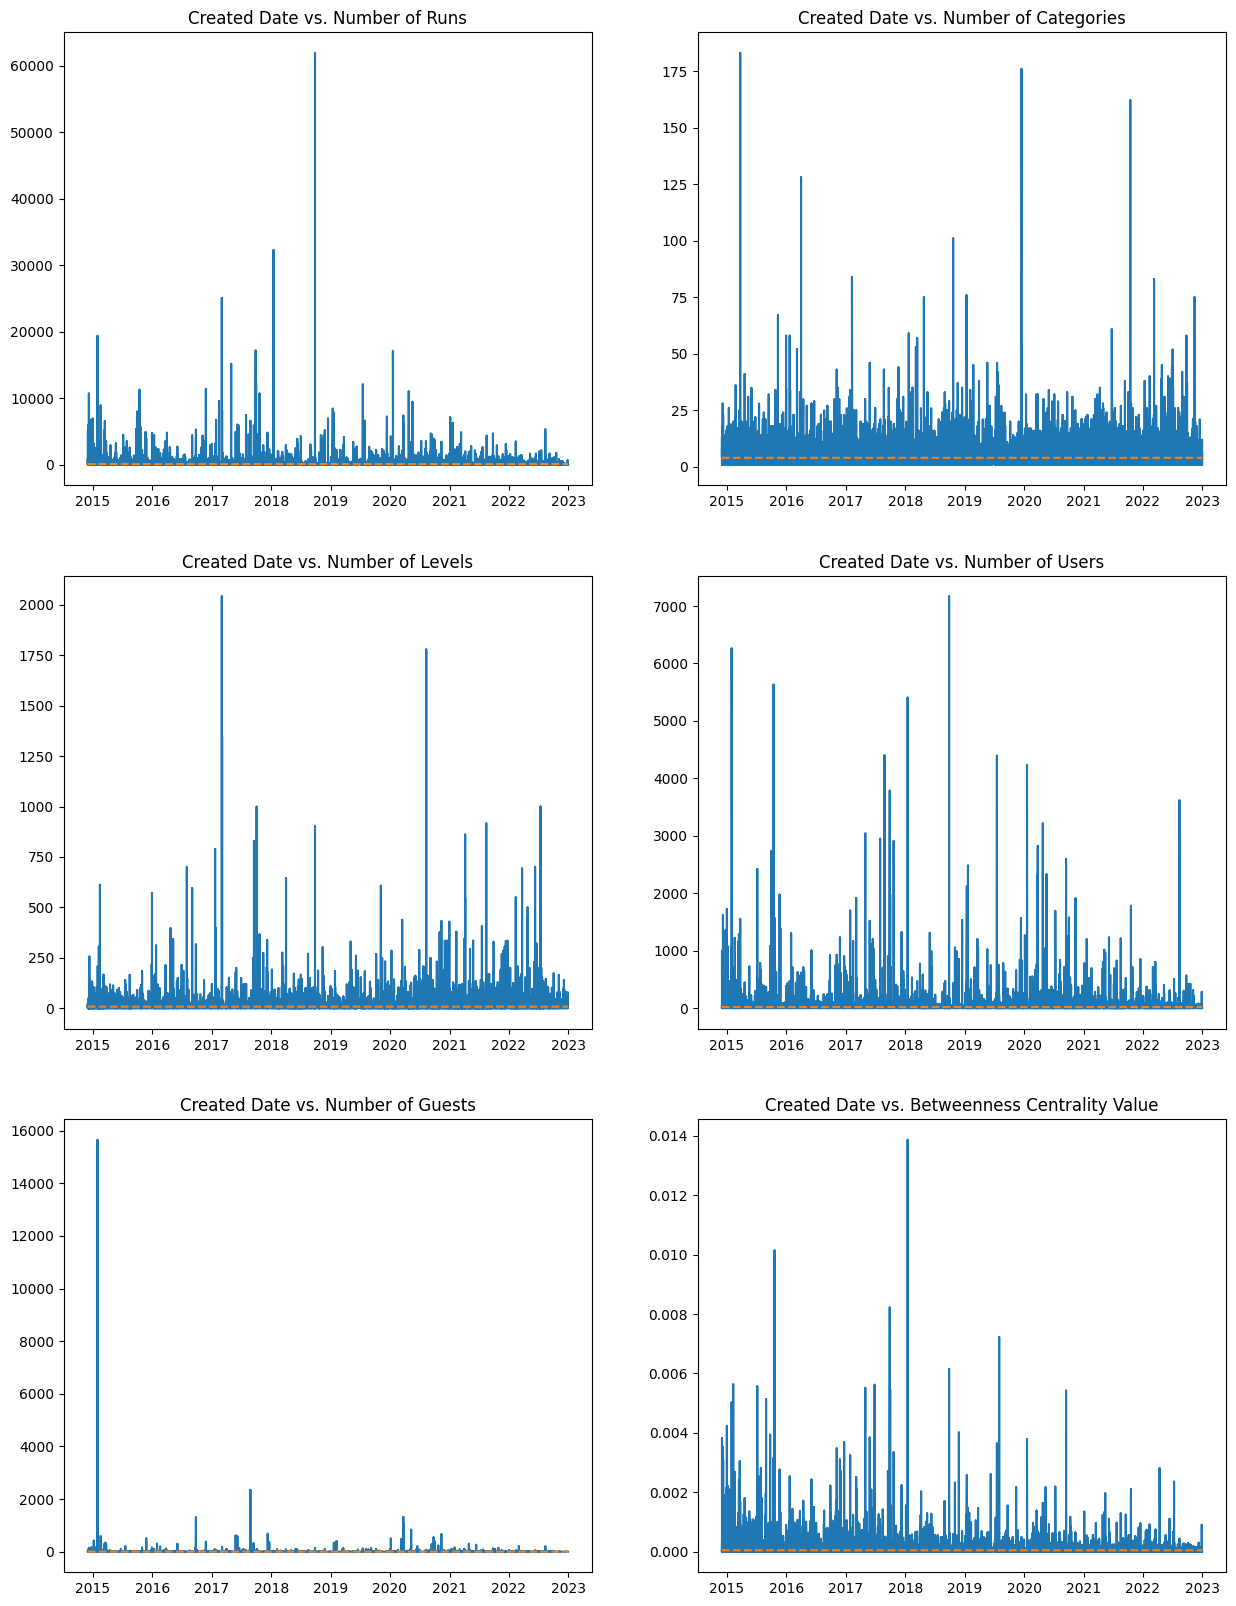

In [81]:
figure, axis = plt.subplots(3, 2)

df = format_games_metadata_dataframe(merged_df).sort_values(by='created_date')
axis[0, 0].plot(df['created_date'], df['num_runs'])
mean = [np.mean(df['num_runs'])]*len(df['created_date'])
axis[0, 0].plot(df['created_date'], mean, linestyle='--')
axis[0, 0].set_title("Created Date vs. Number of Runs")

axis[0, 1].plot(df['created_date'], df['num_categories'])
mean = [np.mean(df['num_categories'])]*len(df['created_date'])
axis[0, 1].plot(df['created_date'], mean, linestyle='--')
axis[0, 1].set_title("Created Date vs. Number of Categories")

axis[1, 0].plot(df['created_date'], df['num_levels'])
mean = [np.mean(df['num_levels'])]*len(df['created_date'])
axis[1, 0].plot(df['created_date'], mean, linestyle='--')
axis[1, 0].set_title("Created Date vs. Number of Levels")

axis[1, 1].plot(df['created_date'], df['num_users'])
mean = [np.mean(df['num_users'])]*len(df['created_date'])
axis[1, 1].plot(df['created_date'], mean, linestyle='--')
axis[1, 1].set_title("Created Date vs. Number of Users")

axis[2, 0].plot(df['created_date'], df['num_guests'])
mean = [np.mean(df['num_guests'])]*len(df['created_date'])
axis[2, 0].plot(df['created_date'], mean, linestyle='--')
axis[2, 0].set_title("Created Date vs. Number of Guests")

axis[2, 1].plot(df['created_date'], df['betweenness_value'])
mean = [np.mean(df['betweenness_value'])]*len(df['created_date'])
axis[2, 1].plot(df['created_date'], mean, linestyle='--')
axis[2, 1].set_title("Created Date vs. Betweenness Centrality Value")

df = df.sort_index()

figure.set_figwidth(15)
figure.set_figheight(20)

plt.show()

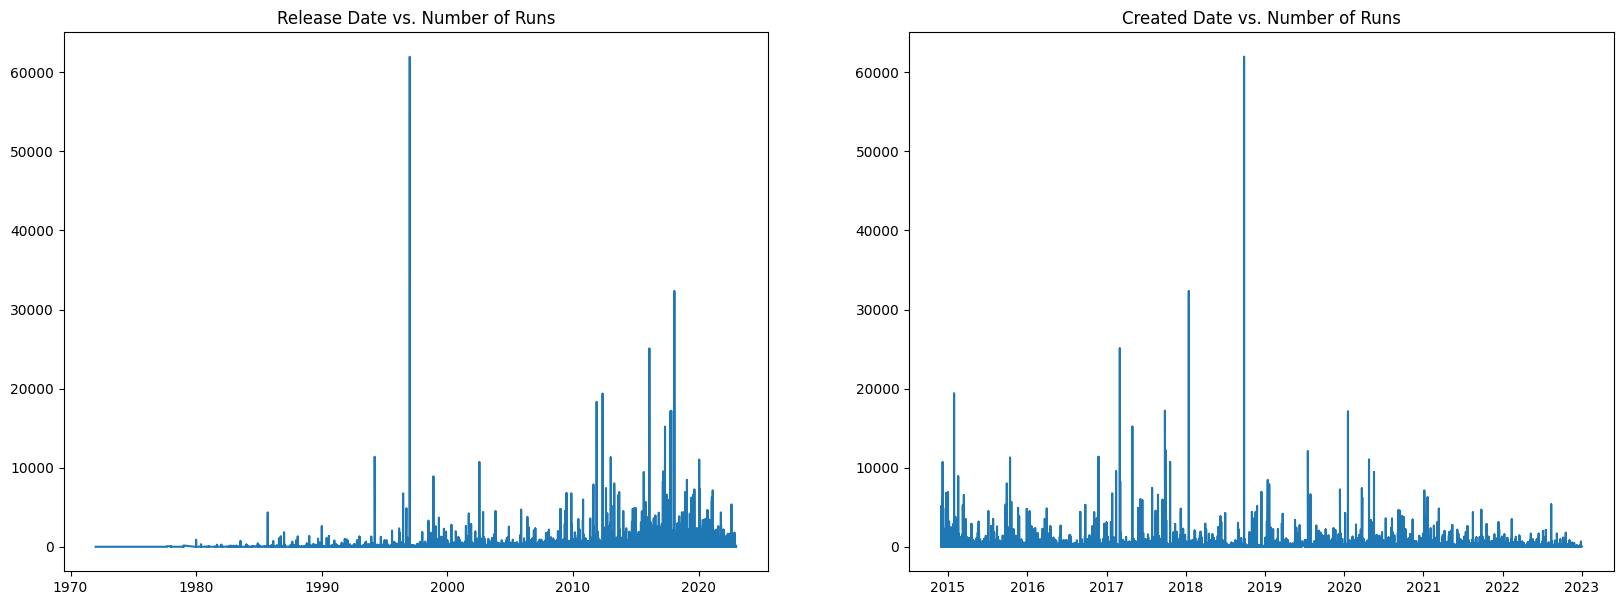

In [82]:
figure, axis = plt.subplots(1, 2)

df = df.sort_values(by='release_date')
axis[0].plot(df['release_date'], df['num_runs'])
axis[0].set_title("Release Date vs. Number of Runs")

df = df.sort_values(by='created_date')
axis[1].plot(df['created_date'], df['num_runs'])
axis[1].set_title("Created Date vs. Number of Runs")

df = df.sort_index()

figure.set_figwidth(20)
figure.set_figheight(7)

plt.show()

In [ ]:
# Cleanup
del closeness_centrality_filename, hits_centrality_filename, pagerank_filename, betweenness_centrality_filename, games_metadata_filename, \
    closeness_centrality_df, hits_centrality_df, pagerank_df, betweenness_centrality_df, games_metadata_df, merged_df, \
    grouped_merged_df, developer, response, figure, axis, df, mean, top_n_values, hub_df, bc_df, bc_df_without_none, closeness_df, all_dataframes

## Discrepancy between Files and Graphs

In [85]:
def find_difference_between_metadata_and_network(metadata_filename, graph_filename):
    metadata_games, network_games = set(), set()

    with open(graph_filename, 'r') as openfile:
            csv_reader = csv.reader(openfile)
            next(csv_reader)
            [network_games.add(row[0]) for row in csv_reader]

    with open(metadata_filename, 'r') as openfile:
            csv_reader = csv.reader(openfile)
            next(csv_reader)
            [metadata_games.add(row[0]) for row in csv_reader]

    return list(network_games - metadata_games)

def find_number_of_games(filename):
        games = set()
        with open(filename, 'r') as openfile:
                csv_reader = csv.reader(openfile)
                next(csv_reader)
                [games.add(row[0]) for row in csv_reader]
                [games.add(row[1]) for row in csv_reader]
        return len(games)

def find_missing_games_from_network(metadata_filename, graph_filename):
    edges = get_weighted_edges_from_csv(graph_filename, filter=None)
    graph = generate_graph_from_edges(edges)

    nodes = set(graph.nodes)
    games = set()
    with open(metadata_filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        [games.add(row[0]) for row in csv_reader]
    return list(games - nodes)

We are trying to find the discrepancy in games from the generated graph and the list of games in `data/games/metadata/all_games.csv`. We find that there are 2016 games missing from the generated network and the list of games.  There are a couple scenarios where a game is not present in the network:
 1. A game has zero runs;
 2. A game is played by ONLY guests;
 3. A game is played by users, but those users have only played the one game. Since we are not allowing edges with the same source and target, they are not present in the network.

In [86]:
find_difference_between_metadata_and_network("../data/games/metadata/all_games.csv", "../data/too_big/all_games.csv")

['4d7e8g67', 'k6qw78o6']

In [87]:
missing_games = find_missing_games_from_network("../data/games/metadata/all_games.csv", "../data/too_big/all_games.csv")
print(f"Number of missing games: {len(missing_games)}")
del missing_games

## Louvain Communities

There are **284 communities** found this way.

In [58]:
games_metadata_filename = "../data/games/metadata/all_games.csv"
games_metadata_df = pd.read_csv(games_metadata_filename)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [59]:
louvain_communities_df = pd.read_csv("../data/games/network/communities/louvain_communities.csv").rename(columns = {'node_id': 'id'})
merged_df = games_metadata_df.merge(louvain_communities_df, on='id', how='inner')
merged_df[['id', 'game_name', 'community_num']].sort_values(by='community_num')

,id,game_name,community_num
2245,76r3x5l6,Spellbound Dizzy,0
26613,ldejp8x1,Cocoa 2: Twenty Four Hour Parsley People,0
199,m1m04362,Forbidden Forest,0
26759,268eyxk6,DRIFT!,0
1771,j1newl91,Magicland Dizzy,0
...,...,...,...
13723,kdkz722d,Numz,283
14048,3698oxld,Nimball: Rewind,283
10341,w6jlr7ed,Dobrynya Nikitich i Zmey Gorynych,284
11599,yd4o97w1,Il'ya Muromets i Solovey-Razboynik,284


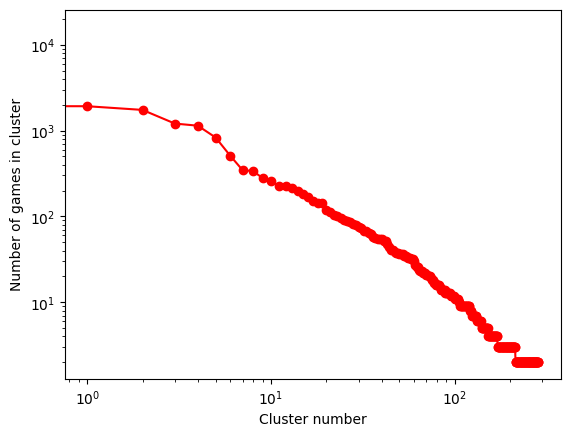

In [11]:
_, counts = list(zip(*sorted(Counter(louvain_communities_df['community_num']).items(), key=itemgetter(1), reverse=True)))
x = [i for i in range(0, len(counts))]
plt.loglog(x, counts, 'ro-')
plt.xlabel("Cluster number")
plt.ylabel("Number of games in cluster")
plt.show()

In [62]:
game_ids = list(merged_df[(merged_df['community_num'] == 23)]['id'])
merged_df[(merged_df['id'].isin(game_ids))].sort_values(by='num_runs').tail(20).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,community_num
4671,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452,23
22112,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14,23
21733,76r55vd8,Super Mario Odyssey,xv6dvx62,2017-10-27,2017-09-27T00:35:19Z,6,0,17212,3790,45,23
21027,46w0n91r,Mario Kart 8 Deluxe,xv6dvx62,2017-04-28,2017-04-30T00:26:59Z,10,0,15196,3046,20,23
11395,4pd0n31e,Portal,leqm52zw,2007-10-09,None,7,24,13867,3448,65,23
21625,w6jmm26j,Cuphead,rzjkx7el,2017-09-29,2017-09-30T04:05:51Z,19,31,12221,1984,44,23
3669,m1zoemd0,Super Metroid,"1zkdw96j,xv6dvx62,y4zw106k",1994-03-19,2016-11-25T20:23:44Z,11,0,11381,1232,379,23
21656,pd0wx9w1,Getting Over It With Bennett Foddy,v6dvjp62,2017-10-06,2017-10-21T23:44:59Z,3,10,10704,2908,4,23
7858,v1pxjz68,Super Mario Sunshine,xv6dvx62,2002-07-19,2014-12-07T12:50:20Z,11,14,10701,1616,147,23
1765,pd0wq31e,Super Mario World,xv6dvx62,1990-11-21,None,13,0,9820,1830,38,23


 * 0 - Dizzy game series, Jet Set Willy series, others
 * 1 - Chirpy Reverie series
 * 2 - Two horror games
 * 3 - Some ROBLOX games, random games
 * 4 - Games from Japan
 * 5 - Karting games (Markio Kart), games from Nintendo
 * 6 - ?
 * 7 - Pokemon Mystery Dungeons, I Spy series
 * 8 - Web games, Mobile Games, Roblox games, Dadish series, 
 * 9 - Need for speed series, driving games, driving simulation, card games
 * 10 - Random PC games?
 * 11 - F1 series, some other racing games
 * 12 - ?
 * 13 - Asterix series, European games, Kot Leopold (Leopold the cat), Garfield
 * 14 - Metal Gear Solid series, shooting games
 * 15 - More Pokemon Mystery Dungeons
 * 16 - ?
 * 17 - Starshine Legacy episodes
 * 18 - Transformers games, Mario vs. Donkey Kong games, LEGO games
 * 19 - ?
 * 20 - Bendy series, Minecraft Dungeons
 * 21 - Grand Theft Auto series, Rockstar Games, some FIFA games, Saints Row series, Football games
 * 22 - Simulation games
 * 23 - Nintendo games, 'typical speedrun' games, Valve games, popular games in general
 * 24 - Minecraft games
 * 25 - Granny series, Sonic games, web games, horror games
 * 26 - Doom games, other random games
 * 27 - LEGO games, Ben 10 games, old CoD games, Doctor Who games
 * 28 - ?
 * 29 - ROBLOX games, some Mario games, random games
 * 30 - ?
 * 31 - ?
 * 32 - Two random games
 * 33 - Super Mario World rom hacks
 * 34 - Moto X3M series, random games
 * 35 - ?
 * 36 - Rec Room series
 * 37 - Hello Neighbour series, horror games
 * 38 - Minecraft games, web games, some ROBLOX games, random other games
 * 39 - Red Ball series, Five Nights games
 * 40 - Robokill series
 * 41 - ?

In [13]:
del games_metadata_df, louvain_communities_df, merged_df, counts, x

## Greedy Modularity Communities

There are **98 communities** found this way.

In [63]:
games_metadata_filename = "../data/games/metadata/all_games.csv"
games_metadata_df = pd.read_csv(games_metadata_filename)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [64]:
greedy_modularity_communities_df = pd.read_csv("../data/games/network/communities/greedy_modularity_communities.csv").rename(columns = {'node_id': 'id'})
merged_df = games_metadata_df.merge(
    greedy_modularity_communities_df, on='id', how='inner')
merged_df[['id', 'game_name', 'community_num']].sort_values(by='community_num')


,id,game_name,community_num
0,j1n8nj91,Computer Space,0
17977,nd29y360,I Wanna Go The Floatkid,0
17976,o1y4nk1q,Plug & Play,0
29489,j1lq2rv6,Winter Ember,0
17973,y65kq86e,The Curse of Anubis,0
...,...,...,...
16709,k6qw22m6,Legend of Equip > Pants,96
20854,o6gl8e5d,Last Tale,97
21068,76rxlre6,HellGunner,97
13723,kdkz722d,Numz,98


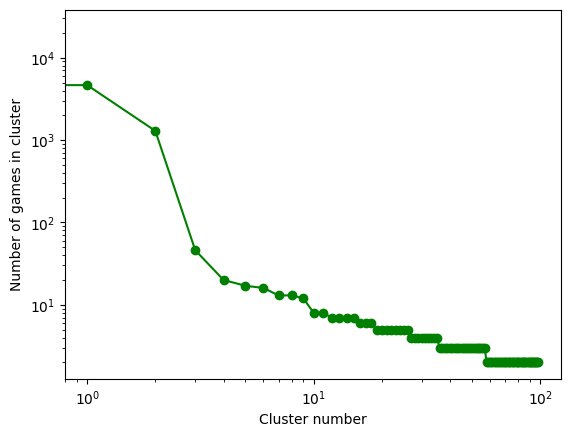

In [17]:
cluster_num, counts = list(zip(*sorted(Counter(greedy_modularity_communities_df['community_num']).items(), key=itemgetter(1), reverse=True)))
plt.loglog(cluster_num, counts, 'go-')
plt.xlabel("Cluster number")
plt.ylabel("Number of games in cluster")
plt.show()

In [81]:
game_ids = list(merged_df[(merged_df['community_num'] == 0)]['id'])
merged_df[(merged_df['id'].isin(game_ids))].sort_values(by='num_runs').tail(20).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,community_num
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,0
4671,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452,0
22112,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14,0
15305,yd478gde,Minecraft: Legacy Console Edition,"yzom2keq,yge00xep",2012-05-09,2015-01-29T23:42:25Z,11,12,19379,155,15646,0
14843,j1npme6p,Minecraft: Java Edition,k62d97ex,2011-11-18,2015-01-29T23:41:21Z,15,0,18329,6268,491,0
21733,76r55vd8,Super Mario Odyssey,xv6dvx62,2017-10-27,2017-09-27T00:35:19Z,6,0,17212,3790,45,0
21613,o1y9pyk6,Google Snake,pe1wp36o,2017-09-27,2020-01-19T12:16:58Z,11,32,17105,4236,8,0
21027,46w0n91r,Mario Kart 8 Deluxe,xv6dvx62,2017-04-28,2017-04-30T00:26:59Z,10,0,15196,3046,20,0
11395,4pd0n31e,Portal,leqm52zw,2007-10-09,None,7,24,13867,3448,65,0
21625,w6jmm26j,Cuphead,rzjkx7el,2017-09-29,2017-09-30T04:05:51Z,19,31,12221,1984,44,0


## Infomap Communities

In [52]:
games_metadata_filename = "../data/games/metadata/all_games.csv"
games_metadata_df = pd.read_csv(games_metadata_filename)
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [53]:
infomap_communities_df = pd.read_csv("../data/games/network/communities/infomap_communities.csv").rename(columns = {'node_id': 'id'})
merged_df = games_metadata_df.merge(
    infomap_communities_df, on='id', how='inner')
merged_df[['id', 'game_name', 'community_num']].sort_values(by='community_num')

,id,game_name,community_num
15219,4d7n9nr6,The Paint Gunner,0
8721,y654we8d,Dr Seuss: Green eggs and ham (GBA),0
23036,kdkzwqqd,Bhop GO,0
23035,369pvn81,Vampire's Fall: Origins,0
23031,o1y953k6,NBA 2K19,0
...,...,...,...
12718,36989g2d,CID The Dummy,433
23134,3dx2q9p1,Into The Aether,434
28865,3dxkr8g1,AfterEffect DX: Directors Cut,434
27551,268we5k6,The Lost Legends of Redwall: The Scout Act 2,435


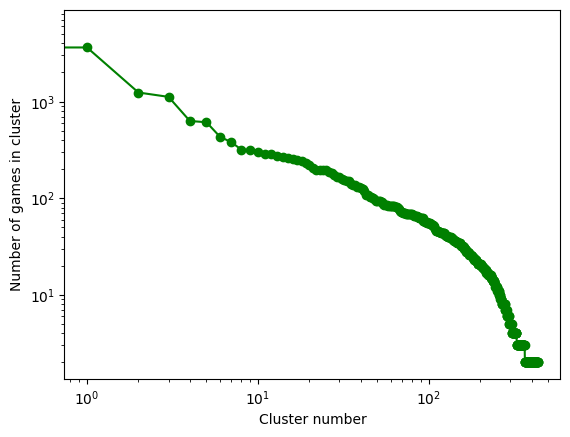

In [21]:
cluster_num, counts = list(zip(*sorted(Counter(infomap_communities_df['community_num']).items(), key=itemgetter(1), reverse=True)))
plt.loglog(cluster_num, counts, 'go-')
plt.xlabel("Cluster number")
plt.ylabel("Number of games in cluster")
plt.show()

In [55]:
game_ids = list(merged_df[(merged_df['community_num'] == 1)]['id'])
merged_df[(merged_df['id'].isin(game_ids))].sort_values(
    by='num_runs').tail(20).iloc[::-1]


,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,community_num
21625,w6jmm26j,Cuphead,rzjkx7el,2017-09-29,2017-09-30T04:05:51Z,19,31,12221,1984,44,1
3669,m1zoemd0,Super Metroid,"1zkdw96j,xv6dvx62,y4zw106k",1994-03-19,2016-11-25T20:23:44Z,11,0,11381,1232,379,1
1765,pd0wq31e,Super Mario World,xv6dvx62,1990-11-21,None,13,0,9820,1830,38,1
463,om1m3625,Super Mario Bros.,xv6dvx62,1985-09-13,None,5,0,8018,1737,31,1
2252,9d3rr0dl,The Legend of Zelda: A Link to the Past,xv6dvx62,1991-11-21,None,4,0,7949,2063,46,1
1019,l3dx51yv,Super Mario Bros. 3,xv6dvx62,1988-10-23,None,4,0,4393,1016,8,1
462,y658506e,Super Mario Bros. Category Extensions,None,1985-09-13,2016-11-05T05:30:59Z,43,0,4351,785,6,1
28455,3dxkz0v1,Metroid Dread,None,2021-10-08,2021-08-17T20:18:49Z,8,0,4350,1213,1,1
25545,76rxmxq6,Streets of Rage 4,"4zwny0zk,rzjqd7el",2020-04-30,2020-05-02T06:58:42Z,19,21,3403,280,34,1
22993,lde3k956,The Messenger,yz8m996w,2018-08-30,2018-08-30T14:46:37Z,5,0,3018,436,1,1


## Measuring Community Detection Performance

In [26]:
cluster_nums = louvain_communities_df['community_num'].unique()
louvain = []
for cluster_num in cluster_nums:
    tmp_cluster = list(louvain_communities_df[(louvain_communities_df['community_num'] == cluster_num)]['id'])
    louvain.append(tmp_cluster)

cluster_nums = greedy_modularity_communities_df['community_num'].unique()
clauset_newman_moore = []
for cluster_num in cluster_nums:
    tmp_cluster = list(greedy_modularity_communities_df[(greedy_modularity_communities_df['community_num'] == cluster_num)]['id'])
    clauset_newman_moore.append(tmp_cluster)

cluster_nums = greedy_modularity_communities_df['community_num'].unique()
infomap = []
for cluster_num in cluster_nums:
    tmp_cluster = list(greedy_modularity_communities_df[(
        greedy_modularity_communities_df['community_num'] == cluster_num)]['id'])
    infomap.append(tmp_cluster)

In [27]:
algorithms = ['clauset_newman_moore', 'louvain', 'infomap']
modularity = [nx.community.modularity(filtered_graph, eval(algorithm)) for algorithm in algorithms]
coverage, performance = map(list, zip(*[nx.community.partition_quality(filtered_graph, eval(algorithm)) for algorithm in algorithms]))

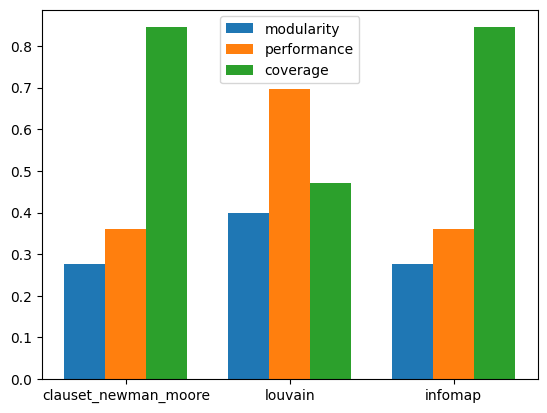

In [28]:
width = 0.25
ind = np.arange(len(algorithms))
plt.bar(ind - width, modularity, width, label='modularity')
plt.bar(ind, performance, width, label='performance')
plt.bar(ind + width, coverage, width, label='coverage')
plt.legend(loc='best')
plt.xticks(ind, algorithms)
plt.show()

In [ ]:
del games_metadata_filename, games_metadata_df, greedy_modularity_communities_df, merged_df, cluster_num, counts
del louvain_communities_df, x
del cluster_nums, louvain, clauset_newman_moore, algorithms, modularity, performance, coverage

## Using Output from Node2vec

In [94]:
import pandas as pd 

cluster_df = pd.read_csv("../data/games/network/communities/all_games_homophily_clusters.csv")
cluster_number = 0
cluster_df_by_number = cluster_df[(cluster_df['cluster_num'] == cluster_number)]
cluster_games = list(cluster_df_by_number['id'])

In [95]:
filter_map = generate_network_filter("../data/games/metadata/all_games.csv", allowed_games=cluster_games)
edge_list = get_weighted_edges_from_csv("../data/too_big/all_games.csv", filter_map)
graph = generate_graph_from_edges(edge_list)
print(len(cluster_games), graph.order(), graph.size())

2154 2154 795137


In [ ]:
del cluster_df, cluster_number, cluster_df_by_number, cluster_games
del filter_map, edge_list

In [96]:
save_weighted_graph(graph, '../data/too_big/cluster_0_homophily.csv')